# Accuracy vs Mag DEIMOS Spec Test Set

In this notebook we examine the accuracy as a function of magnitude for sources with spectroscopic classifications from DEIMOS COSMOS survey. The DEIMOS set contains $\sim$ 10K sources, and $\sim$ 2.7K sources are crossmatched with PS1 catalog. 

The overall accuracy for the classification by the ML model we developed is $\sim$ 95%, but the FoM @FPR=0.05 is lower than 0.4, which is worse than the FoM obtained with HSTxPS1 catalog.  Although the uncertainty of the accuracy and the FoM should be larger than that with the HSTxPS1 catalog because the number of sources contained in the DEIMOSxPS1 is much smaller, we have to investigate the reason for it. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
_df = pd.read_table('DEIMOS/deimos_10K_March2018/deimos.tbl', header=None)

In [3]:
arr = np.empty((len(_df), len(_df.iloc[0][0].split())), dtype='<U50')

for i in range(len(_df)):
    i_row = [k for k in _df.iloc[i][0].split('  ') if (k != '')and(k != ' ')]
    for j in range(len(_df.iloc[0][0].split())):
        arr[i][j] = i_row[j]

In [4]:
df = pd.DataFrame(arr)

In [5]:
ra = np.array(df[1], dtype=float)
dec = np.array(df[2], dtype=float)
sel = np.array(df[3], dtype=int)
imag = np.array(df[4].replace('null', '-999').replace(' null', '-999'), dtype=float)
kmag = np.array(df[5].replace('null', '-999').replace(' null', '-999'), dtype=float)
zspec = np.array(df[6].replace('null', '-999').replace(' null', '-999'), dtype=float)
Qflag = np.array(df[7].replace('null', '-999').replace(' null', '-999'), dtype=int)
Q  = np.array(df[8].replace('null', '-999').replace(' null', '-999'), dtype=float)

In [6]:
np.array(df[9][0:20])

array([' H+K?', ' [OII],[OIII]', ' [OIII]d', ' M star', ' [OII],H+K?',
       ' star', ' Hg,[OIII]?', ' star', ' [OII],[OIII]d', ' [OII],Hb',
       ' star', ' Lya,CIV(br),CIII]', ' [OII],K,Hb,MgI', ' [OII]d,K',
       ' [OII]d,H+H,Hb,[OIII]d', ' [OII]d,H+K', ' [OII],Hb,[OIII]d',
       ' [OII],K,Hb', ' Hb(abs),Ha?', ' [OII]d'], dtype=object)

In [7]:
sgFlag = np.empty(len(df), dtype=int)

for i in range(len(df[9])):
    if 'star' in df[9][i]:
        sgFlag[i] = 1 # star
    elif 'null' in df[9][i]:
        sgFlag[i] = -999 # null
    else:
        sgFlag[i] = 0 # galaxy

if "Remarks" contains "star", the source is classifyed star. 

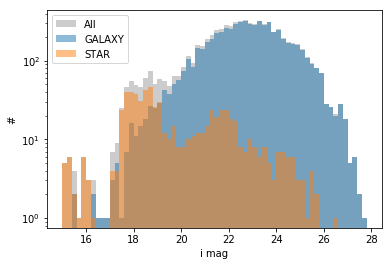

In [41]:
plt.hist(imag[sgFlag!=-999], bins=np.arange(15, 28, 0.2), color='0.8', label='All')
plt.hist(imag[sgFlag==0], bins=np.arange(15, 28, 0.2), alpha=0.5, label='GALAXY')
plt.hist(imag[sgFlag==1], bins=np.arange(15, 28, 0.2), alpha=0.5, label='STAR')
plt.yscale('log')
plt.xlabel('i mag'); plt.ylabel('#')
plt.legend(loc='best')
plt.show()

The distribution of galaxies looks similar to that of the HST COSMOS catalog, but that of stars has a peak at i-mag$\sim$22, which is not shown in that of the HSTxPS1 catalog.   

In [9]:
df = pd.DataFrame()
df['ra'] = ra; df['dec'] = dec
df['sel'] = sel 
df['imag'] = imag; df['kmag'] = kmag
df['zspec'] = zspec
df['Qflag'] = Qflag; df['Q'] = Q
df['class'] = sgFlag

In [42]:
df[0:10]

,ra,dec,sel,imag,kmag,zspec,Qflag,Q,class
0,149.358553,2.750301,512,20.11,20.19,0.5655,2,1.5,0
1,149.366394,2.376694,128,22.89,21.73,0.7080,3,2.0,0
2,149.369095,2.344088,128,21.73,19.99,0.7080,3,2.0,0
3,149.373750,2.776508,2,18.17,17.13,0.0000,4,2.0,1
4,149.374100,2.736905,2,21.37,19.37,0.5490,2,1.5,0
5,149.374496,2.415250,2,15.41,15.14,0.0000,4,2.0,1
6,149.375504,2.423475,128,24.28,21.87,1.0790,1,1.5,0
7,149.377594,2.363211,2,18.49,18.14,0.0000,4,2.0,1
8,149.381103,2.361963,512,21.84,20.43,0.7720,4,2.0,0
9,149.382095,2.409508,128,22.50,20.64,0.9300,3,2.0,0


In [11]:
df.to_csv('./DEIMOS/DEIMOS.csv', index=None)

In [12]:
import star_galaxy_models
rf_obj = star_galaxy_models.RandomForestModel()
rf_obj.read_rf_from_pickle()

In [13]:
features = ['wwpsfChiSq', 'wwExtNSigma', 'wwpsfLikelihood',
            'wwPSFKronRatio', 'wwPSFKronDist',  'wwPSFApRatio',
            'wwmomentRH', 'wwmomentXX', 'wwmomentXY', 'wwmomentYY', 
            'wwKronRad']

In [14]:
from sklearn.metrics import roc_curve, accuracy_score, auc, make_scorer

### ROC curve and Accuracy 

In [15]:
ps1_dei = pd.read_csv('./DEIMOS/PS1_DEIMOS_features.csv').drop_duplicates(subset='objid')
print("PS1xDEIMOS catalog constains %i sources."%len(ps1_dei))

PS1xDEIMOS catalog constains 4481 sources.


In [16]:
ps1_dei_det_mask = np.logical_and(ps1_dei['class'] != -999, (ps1_dei.nDetections>0)&(ps1_dei.wwKronFlux>0))
ps1_dei = ps1_dei[ps1_dei_det_mask]
print("%i sources are classified by both of DEIMOS and ML model."%len(ps1_dei))

2709 sources are classified by both of DEIMOS and ML model.


In [17]:
ps1_df = pd.read_csv('./DEIMOS/HST_COSMOS_features.csv')

In [18]:
dupl_mask = np.empty(len(ps1_dei), dtype=bool)
for i in range(len(dupl_mask)):
    dupl_mask[i] = ps1_dei.objid.iloc[i] in np.array(ps1_df.objid)
    
ps1_dei = ps1_dei[~dupl_mask]
print("%i sources are not contained in PS1xHST catalog."%len(ps1_dei))

2674 sources are not contained in PS1xHST catalog.


In [19]:
kron_mag = -2.5*np.log10(ps1_dei.wwKronFlux/3631)
ps1_dei_features = ps1_dei[features]
ps1_dei_class = ps1_dei['class']

In [20]:
ps1_dei_score = rf_obj.rf_clf_.predict_proba(ps1_dei_features)
ps1_dei_pred = rf_obj.rf_clf_.predict(ps1_dei_features)

In [21]:
print("Overall accuracy of the classification by the ML model is %f"%accuracy_score(ps1_dei_class, ps1_dei_pred))

Overall accuracy of the classification by the ML model is 0.949140


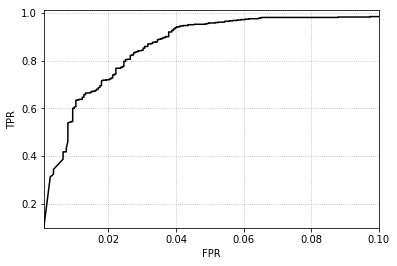

In [22]:
fpr, tpr, thre = roc_curve(ps1_dei_class, ps1_dei_score[:,1])
plt.grid(linestyle='dotted')
plt.plot(fpr, tpr, 'k-')
#plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-3, 1e-1); plt.ylim(0.1, 1.01)
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.show()

In [23]:
ps1_dei_class = np.array(ps1_dei_class)
ps1_dei_score = np.array(ps1_dei_score)
kron_mag = np.array(kron_mag)

binwidth = 1.5
Nboot = 100
mag_array = np.arange(14 , 23+binwidth, binwidth)
kron_mag = np.array(-2.5*np.log10(ps1_dei['wwKronFlux']/3631))

ml_acc_arr = np.zeros_like(mag_array, dtype=float)
ml_boot_scatt = np.vstack((np.zeros_like(mag_array, dtype=float), np.zeros_like(mag_array, dtype=float)))

for bin_num, binedge in enumerate(mag_array):
    bin_sources = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth))
    ml_acc_arr[bin_num] = accuracy_score(ps1_dei_class[bin_sources], 
                                         ps1_dei_pred[bin_sources])
    ml_boot_acc = np.empty(Nboot)
    for i in range(Nboot):
        boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]), 
                                        replace=True)
        ml_boot_acc[i] = accuracy_score(ps1_dei_class[boot_sources], 
                                         ps1_dei_pred[boot_sources])

    ml_boot_scatt[:,bin_num] = np.percentile(ml_boot_acc, [16, 84])

In [24]:
from sklearn.neighbors import KernelDensity
kde_grid = np.linspace(10,26,200)
deimos_stars = np.where(ps1_dei_class == 1)
deimos_gal = np.where(ps1_dei_class == 0)
deimos_kde_gal_norm = len(deimos_gal[0])/len(ps1_dei_class)
deimos_kde_star_norm = 1 - deimos_kde_gal_norm

kde_deimos = KernelDensity(bandwidth=1.059*np.std(kron_mag, ddof=1)*len(kron_mag)**(-0.2),
                         rtol=1E-4)
kde_deimos.fit(kron_mag[:, np.newaxis])

kde_deimos_stars = KernelDensity(bandwidth=1.059*np.std(kron_mag[deimos_stars], ddof=1)*len(kron_mag[deimos_stars])**(-0.2),
                               rtol=1E-4)
kde_deimos_stars.fit(kron_mag[deimos_stars[0], np.newaxis])

kde_deimos_gal = KernelDensity(bandwidth=1.059*np.std(kron_mag[deimos_gal], ddof=1)*len(kron_mag[deimos_gal])**(-0.2),
                             rtol=1E-4)
kde_deimos_gal.fit(kron_mag[deimos_gal[0], np.newaxis])

pdf_deimos = np.exp(kde_deimos.score_samples(kde_grid[:, np.newaxis]))
pdf_deimos_stars = np.exp(kde_deimos_stars.score_samples(kde_grid[:, np.newaxis]))
pdf_deimos_gal = np.exp(kde_deimos_gal.score_samples(kde_grid[:, np.newaxis]))

/Users/tachibana/.pyenv/versions/anaconda2-4.0.0/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


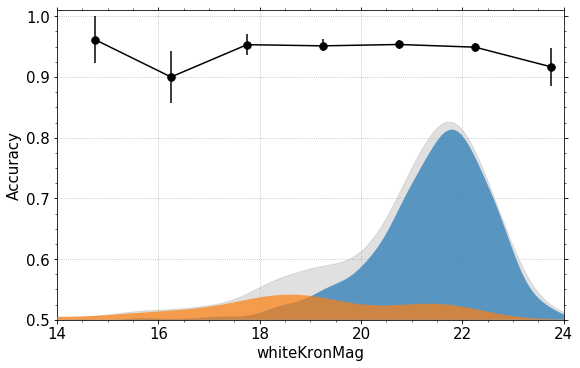

In [35]:
from matplotlib.ticker import MultipleLocator
#import seaborn as sns
color_dict = {'ml': "black"}

mag_bin_centers = mag_array + binwidth/2
#cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
#cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 5))

ax.grid(linestyle='dotted', zorder=1)
ax.errorbar(mag_bin_centers, ml_acc_arr, 
            yerr=np.abs(ml_boot_scatt - ml_acc_arr), 
            ls='-', lw=.75, fmt='o',
            color=color_dict['ml'], label="ML model", 
           linewidth=1.5, markersize=7.5, zorder=5)

# add KDE plots
ax.fill(kde_grid, pdf_deimos + 0.5, alpha=0.4, color="0.7", zorder=2)
ax.fill(kde_grid, pdf_deimos_gal*deimos_kde_gal_norm + 0.5, alpha=0.7, zorder=3)#, color=cmap_gal(0.25))
ax.fill(kde_grid, pdf_deimos_stars*deimos_kde_star_norm + 0.5, alpha=0.7, zorder=4)#, color=cmap_star(0.25))

ax.set_ylim(0.5,1.01)
ax.set_xlim(14, 24)
ax.tick_params(which="both", top=True, right=True, labelsize=15)
ax.set_xlabel('whiteKronMag', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)

ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

#ax.legend(bbox_to_anchor=(0.01, 0.3, 1., 0.102), loc=3, fontsize=13)

fig.subplots_adjust(top=0.98,right=0.98,left=0.1,bottom=0.12)